<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 5th exercise: <font color="#C70039">Work with Robust Random Cut Forest (RRCF) algorithms for anomaly detection</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Student: Nicolas Rehbach
* Matriculation Number: 11133387
* Date:   04.11.2022

<img src="https://docs.aws.amazon.com/sagemaker/latest/dg/images/RCF2.jpg" style="float: center;" width="450">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

* <font color=red>Install the RRCF package per pip:_$ pip install rrcf_</font>

The codes of this exercise is based on the codebase of the following team:

_M. Bartos, A. Mullapudi, & S. Troutman, rrcf: Implementation of the Robust Random Cut Forest algorithm for anomaly detection on streams , in: Journal of Open Source Software, The Open Journal, Volume 4, Number 35. 2019_

---------------------

### <font color="ce33ff">DESCRIPTION</font>:
This notebook allows you for learning Amazon's Robust Random Cut Forest algorithm and its implementation for detecting anomalies. The Robust Random Cut Forest Algorithm for anomaly detection was invented by Guha et al. in 2016. Further reading can be found here (&rarr; <a href="http://proceedings.mlr.press/v48/guha16.pdf">paper</a>):

_S. Guha, N. Mishra, G. Roy, & O. Schrijvers, Robust random cut forest based anomaly detection on streams, in Proceedings of the 33rd International conference on machine learning, New York, NY, 2016 (pp. 2712-2721)_.

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
4. take the three data sets from exercize 1 and apply the RRCF to them.
5. interpret the results in writing.
-----------------------------------------------------------------------------------

### Robust random cut trees (part I)
A RRCT can be instantiated from a point set. Points can also be added and removed from an RRCT.

In [29]:
pip install rrcf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import numpy as np
import rrcf

#### A (robust) random cut tree can be instantiated from a point set (n x d)

Downgrading numpy conflicts with tensorflow in the following exercises!

In [31]:
np.__version__

'1.21.6'

In [32]:
X = np.random.randn(30, 2)
tree = rrcf.RCTree(X)

print(tree)

─+
 ├───+
 │   ├───+
 │   │   ├───+
 │   │   │   ├───+
 │   │   │   │   ├──(10)
 │   │   │   │   └──(12)
 │   │   │   └───+
 │   │   │       ├───+
 │   │   │       │   ├──(3)
 │   │   │       │   └──(5)
 │   │   │       └───+
 │   │   │           ├───+
 │   │   │           │   ├───+
 │   │   │           │   │   ├───+
 │   │   │           │   │   │   ├──(16)
 │   │   │           │   │   │   └──(22)
 │   │   │           │   │   └──(1)
 │   │   │           │   └───+
 │   │   │           │       ├──(25)
 │   │   │           │       └──(29)
 │   │   │           └───+
 │   │   │               ├──(15)
 │   │   │               └──(28)
 │   │   └───+
 │   │       ├───+
 │   │       │   ├───+
 │   │       │   │   ├──(20)
 │   │       │   │   └───+
 │   │       │   │       ├──(4)
 │   │       │   │       └──(8)
 │   │       │   └──(14)
 │   │       └──(24)
 │   └───+
 │       ├───+
 │       │   ├──(7)
 │       │   └───+
 │       │       ├───+
 │       │       │   ├──(21)
 │       │       │   └──(

#### A random cut tree can also be instantiated with no points.
The points can be inserted and removed afterwards.

In [33]:
tree = rrcf.RCTree()

#Inserting points at index i
for i in range(6):
    x = np.random.randn(2)
    #print("x=",x)
    tree.insert_point(x, index=i)

print(tree)

#Deleting points at index i 
tree.forget_point(2)

print(tree)

─+
 ├───+
 │   ├──(5)
 │   └──(0)
 └───+
     ├───+
     │   ├──(1)
     │   └───+
     │       ├──(2)
     │       └──(4)
     └──(3)

─+
 ├───+
 │   ├──(5)
 │   └──(0)
 └───+
     ├───+
     │   ├──(1)
     │   └──(4)
     └──(3)



### Robust random cut trees (part II)
#### Anomaly score
The likelihood that a point is an outlier is measured by the so-called <font color=red>collusive displacement (CoDisp)</font> score: if including a new point significantly changes the model's complexity (i.e. bit depth), then that point is more likely to be an outlier.

In [34]:
# Seed the tree with zero-mean, and hence normally distributed data points
X = np.random.randn(100,2)
tree = rrcf.RCTree(X)

# Generate one inlier and one outlier point
inlier = np.array([0, 0])
outlier = np.array([4, 4])

# Insert both points into the tree
tree.insert_point(inlier, index='inlier')
tree.insert_point(outlier, index='outlier')

# Ask for their codisp (anomaly) score
print("tree.codisp('inlier')=",tree.codisp('inlier'))
print("tree.codisp('outlier')=",tree.codisp('outlier'))

tree.codisp('inlier')= 2.5
tree.codisp('outlier')= 33.0


As a rule of thumb:
* scores of max(abs(3 * stdev)) are ok
* higher scores are an indication of an outlier.

### Robust random cut trees (part III)
#### Batch anomaly detection
This example shows how a robust random cut forest can be used to detect outliers in a batch setting. As you already know, outliers correspond to a larger CoDisp score.

In [35]:
import numpy as np
import pandas as pd
import rrcf

In [36]:
'''
In order to create a random forest, we simply create a list of RCTrees, 
with each RCTree constructed from a random sample of the input dataset. 
Let's create a random forest with 100 trees, each containing 256 points 
from the original sample.
'''
# Set parameters
np.random.seed(0)
n = 2010
d = 3
num_trees = 100
tree_size = 256

# Generate a random data set
X = np.zeros((n, d))
X[:1000,0] = 5
X[1000:2000,0] = -5
X += 0.01*np.random.randn(*X.shape)

print(x)
# Construct forest
forest = []
while len(forest) < num_trees:
    # Select random subsets of points uniformly from point set
    ixs = np.random.choice(n, size=(n // tree_size, tree_size),
                           replace=False)
    # Add sampled trees to forest
    trees = [rrcf.RCTree(X[ix], index_labels=ix) for ix in ixs]
    forest.extend(trees)

'''
Finally, to determine outliers we compute the average codisp 
over all trees for each point in the original sample.
'''
# Compute average CoDisp
avg_codisp = pd.Series(0.0, index=np.arange(n))
index = np.zeros(n)
for tree in forest:
    codisp = pd.Series({leaf : tree.codisp(leaf) for leaf in tree.leaves})
    avg_codisp[codisp.index] += codisp
    np.add.at(index, codisp.index.values, 1)
avg_codisp /= index

'''Now, print the average codisp for each set of points.'''
# for the inlier points:
print("AVG_codisp[inlier points]=",round(avg_codisp[:-10].mean(),2))
# for the outlier points:
print("AVG_codisp[outlier points]=",round(avg_codisp[-10:].mean(),2))

[-2.23287757  1.0089253 ]
AVG_codisp[inlier points]= 5.59
AVG_codisp[outlier points]= 73.54


In [37]:
'''
Note that the outlier points again have a larger codisp. 
To classify the original points into inlier and outlier classes, 
perform a simple threshold test on the codisp result.
'''
# For example:
print("Is outlier?\n",avg_codisp > avg_codisp.quantile(0.99))

Is outlier?
 0       False
1       False
2       False
3       False
4       False
        ...  
2005     True
2006     True
2007     True
2008     True
2009     True
Length: 2010, dtype: bool


### Robust random cut trees (part IV)
#### Streaming anomaly detection
This example shows how the algorithm can be used to detect anomalies in streaming time series data.

In [38]:
import numpy as np
import rrcf

# Generate a data set (sine wave with an anomaly inside)
n = 730
A = 50
center = 100
phi = 30
T = 2*np.pi/100
t = np.arange(n)
sin = A*np.sin(T*t-phi*T) + center
sin[235:255] = 80

# Set tree parameters
num_trees = 40
shingle_size = 4
tree_size = 256

# Construct again a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

# Insert streaming points into tree and compute anomaly score
# Use the "shingle" generator to create a rolling window
points = rrcf.shingle(sin, size=shingle_size)

# Create a dict to store anomaly score of each point
avg_codisp = {}

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

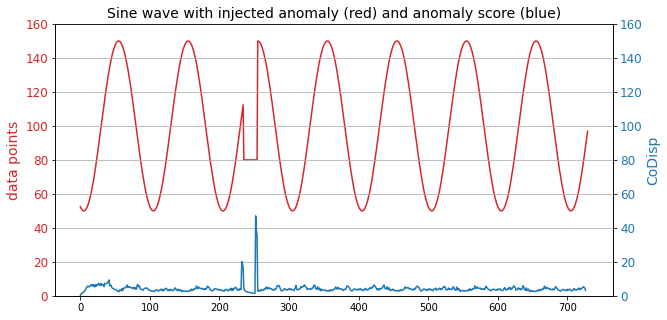

In [39]:
'''visualize the originil time series and the CoDisp score'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_ylabel('data points', color=color, size=14)
ax1.plot(sin, color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.set_ylim(0,160)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CoDisp', color=color, size=14)
ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
ax2.grid('off')
ax2.set_ylim(0, 160)
plt.title('Sine wave with injected anomaly (red) and anomaly score (blue)', size=14)
plt.show()

# Applying RRFC

In [40]:
import pandas as pd
import numpy as np
#import rrfc
import matplotlib.pyplot as plt
import seaborn as sns


from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [41]:
diabetes_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/diabetes.csv')
height_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Height of Male and Female by Country 2022.csv')
weight_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/SOCR-HeightWeight.csv')

diabetes_df = diabetes_df.dropna()
height_df = height_df.dropna()
weight_df = weight_df.dropna()

In [42]:
#Writing a RRFC Function based on the provided algorithm:
# Taking the dataframe, the number of trees and the treesize as parameters
def rrfc(df, num, size):
    #dataframe to numpy array, otherwise there is an error
    df_arr = df.to_numpy()
    np.random.seed(0)
    n, d = df_arr.shape
    num_trees = num
    tree_size = size
    
    #create the forest
    forest = []
    #while the forest is smaller then num trees do:
    while len(forest) < num_trees:
        # ixs is a random point from the dataset
        ixs = np.random.choice(n, size=(n // tree_size, tree_size),
                           replace=False)
        # Add sampled trees to forest
        trees = [rrcf.RCTree(df_arr[ix], index_labels=ix) for ix in ixs]
        forest.extend(trees)
        
    # now we are determining the outliers by using the average codisp.
    # define a pandas series with an index of an even range of n (array rowcount)
    avg_codisp = pd.Series(0.0, index = np.arange(n))
    index = np.zeros(n)
    # for each tree in the forest compute:
    for tree in forest:
        # the codisp is computet by a series of the tree codisp of a leaf for each leaf in the tree
        codisp = pd.Series({leaf: tree.codisp(leaf) for leaf in tree.leaves})
        # add the codisp to the average
        avg_codisp[codisp.index] += codisp
        np.add.at(index, codisp.index.values, 1)
    avg_codisp /= index #(average codisp = avg_codisp / index)
    # for the inlier points:
    print("AVG_codisp[inlier points]=",round(avg_codisp[:-10].mean(),2))
    # for the outlier points:
    print("AVG_codisp[outlier points]=",round(avg_codisp[-10:].mean(),2)) 
    #return the average codisposition of each point
    return(avg_codisp)

In [43]:
def plot_rrfc(df, avg_codisp):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:red'
    ax1.set_ylabel('data points', color=color, size=14)
    ax1.plot(df, color=color)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
    ax1.set_ylim(0,200)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('CoDisp', color=color, size=14)
    ax2.plot(pd.Series(avg_codisp).sort_index(), color=color)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=12)
    ax2.grid('off')
    ax2.set_ylim(0, 200)
    plt.title('Outliers', size=14)
    plt.show()

Dataframe 1:

In [45]:
age_bmi = diabetes_df[['Age', 'BMI']]
bmi_codisp = rrfc(age_bmi, 500, 512)

AVG_codisp[inlier points]= 6.67
AVG_codisp[outlier points]= 6.55


In [54]:
bmi_codisp

0       5.357365
1       3.945930
2       5.285945
3       3.882705
4       6.330758
         ...    
763    11.031689
764     4.315222
765     4.086129
766     5.399438
767     3.621051
Length: 768, dtype: float64

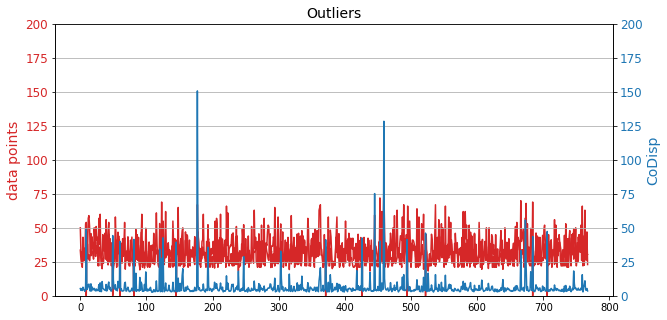

In [47]:
plot_rrfc(age_bmi,bmi_codisp)

In [55]:
outliers = pd.DataFrame(bmi_codisp > bmi_codisp.quantile(0.99))
age_bmi['outlier'] = outliers
age_bmi['codisp'] = bmi_codisp

<ipython-input-55-b6e2ef154cf5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_bmi['outlier'] = outliers
<ipython-input-55-b6e2ef154cf5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_bmi['codisp'] = bmi_codisp


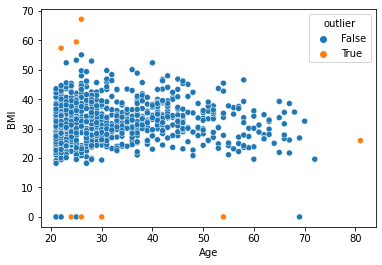

In [56]:
sns.scatterplot(data = age_bmi, x = 'Age', y = 'BMI', hue = 'outlier')

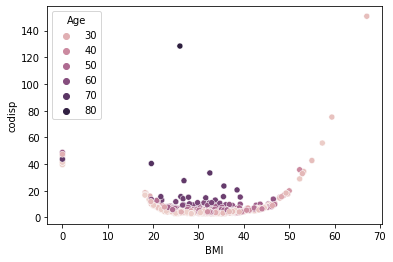

In [60]:
sns.scatterplot(data = age_bmi, x = 'BMI', y = 'codisp', hue = 'Age')

The codisp of the inlier and outlier points are fairly close to another. However, by visualizing the outliers can be detected. Compared to the Isolation Forest, the RRFC did better. However compared to DBScan both algorithms did not find enough outliers.

One can clearly see, how the RRFC did not recognize many of the BMI = 0 anomalies.

Dataframe 2:

In [67]:
height = height_df[['Male Height in Cm', 'Female Height in Cm']]
height_codisp = rrfc(height, 500, 128)

AVG_codisp[inlier points]= 4.59
AVG_codisp[outlier points]= 14.55


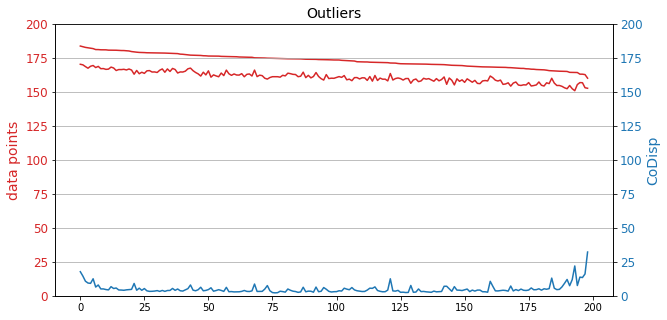

In [68]:
plot_rrfc(height, height_codisp)

In [69]:
outliers = pd.DataFrame(height_codisp > height_codisp.quantile(0.99))
height['outlier'] = outliers
height['codisp'] = height_codisp

<ipython-input-69-98c3376f9eb0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  height['outlier'] = outliers
<ipython-input-69-98c3376f9eb0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  height['codisp'] = height_codisp


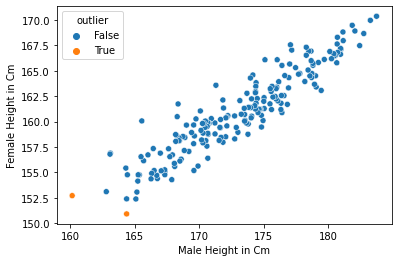

In [70]:
sns.scatterplot(data = height, x = 'Male Height in Cm', y = 'Female Height in Cm', hue = 'outlier')

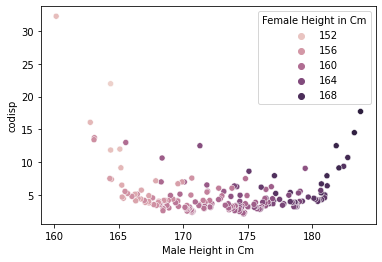

In [71]:
sns.scatterplot(data = height, x = 'Male Height in Cm', y = 'codisp', hue = 'Female Height in Cm')

After trying out several parameters, one can observe that the two smallest countries are categorized as outlier. This comes to no surprise.

In [72]:
weight = weight_df[['Height(Inches)', 'Weight(Pounds)']]
weight_codisp = rrfc(weight, 500, 16384)

AVG_codisp[inlier points]= 9.69
AVG_codisp[outlier points]= 8.75


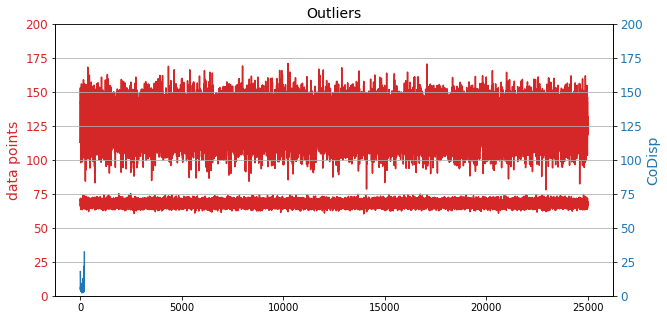

In [73]:
plot_rrfc(weight, height_codisp)

In [74]:
outliers = pd.DataFrame(weight_codisp > weight_codisp.quantile(0.99))
weight['outlier'] = outliers
weight['codisp'] = weight_codisp

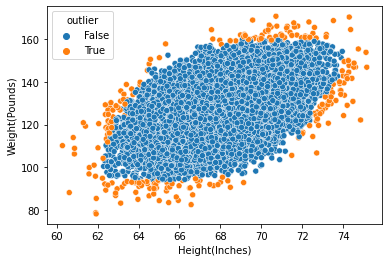

In [75]:
sns.scatterplot(data = weight, x = 'Height(Inches)', y = 'Weight(Pounds)', hue = 'outlier')

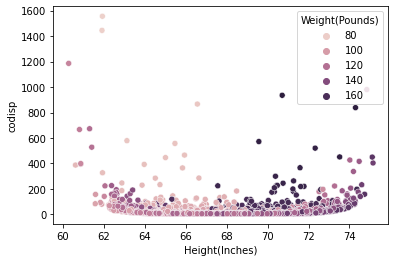

In [76]:
sns.scatterplot(data = weight, x = 'Height(Inches)', y = 'codisp', hue = 'Weight(Pounds)')

In the final example the RRFC found a pretty good solution. While there are still some potential outliers, one can not observe if theres several points with the sam weight and height for example. However, sometimes there are underlying outliers in the points for example in 71.5 inches and 110 pounds. This is not quite intuitive for me. Generally, I could observe that a higher tree size definietly helps the model to find a better solution.

### Personal takeaways:

While the RRFC found good results, they are not perfect. Using a larger amount of trees and treesize definitley enhanced the outcome. 

However, RRFC might be computationally quite expensive. Computing the RRFC for 25000 datapoints for the weight data with 200 trees and a treesize of 4096 took 2 minutes. Using 500 trees and a size of 16384 took about 35 minutes.
When it goes towards millions of datapoints, this approach might not be optimal.